In [2]:
# imports
import os
# import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from dotenv import load_dotenv
from gymnasium import spaces
import matplotlib.patches as patches
import shutil
import sumo_rl

# imports
SUMO_HOME = 'C:\\Program Files (x86)\\Eclipse\\Sumo'

os.environ['SUMO_HOME'] = SUMO_HOME

# Print the SUMO_HOME environment variable to verify
print("SUMO_HOME is set to:", os.environ.get('SUMO_HOME'))

# Check if the SUMO_HOME path exists
print("Does SUMO_HOME exist?", os.path.exists(os.environ.get('SUMO_HOME')))


# Define file paths
net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'
config_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.sumocfg'





SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
Does SUMO_HOME exist? True


# Environment

In [3]:
class Environment:
    def __init__(self, env_name, route_file, net_file, out_csv_name, render_mode='human', num_seconds=100000):
        self.env_name = env_name
        self.use_gui = True if render_mode == 'human' else False
        self.route_file = route_file
        self.net_file = net_file
        self.out_csv_name = out_csv_name
        self.env = gym.make(
                        env_name,
                        net_file=net_file,
                        route_file=route_file,
                        out_csv_name=out_csv_name,
                        use_gui=self.use_gui,
                        num_seconds=num_seconds
                    )
     
        self.state, _ = self.env.reset()
        self.done = False
        self.observation_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space
        self.traffic_signals = self.env.traffic_signals
    
    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        return self.state
    
    def custom_reward(self, traffic_signal, reward_type='average_speed', reward_method='simple'):
        # print("Inside custom reward method")
        if reward_method == 'simple':
            match reward_type:
                case 'average_speed':
                    return traffic_signal.get_avgerage_speed()
                case 'congesion':
                    return -1 * traffic_signal.get_pressure()
                case 'emissions':
                    return -1* traffic_signal.get_emission_co2()
                case 'throughput':
                    return traffic_signal.get_throughput()

        else:
            # Weighted sum of the metrics
            reward = 0
            if weights is None:
                weights = {
                    'average_speed': 0.4,
                    'waiting_time': 0.3,
                    'emissions': 0.2,
                    'throughput': 0.1
                }

            # Calculate individual rewards
            average_speed = traffic_signal.get_average_speed()
            waiting_time = -1* traffic_signal._diff_waiting_time_reward()
            total_queue = -1 * traffic_signal.get_total_queued()
            congesion = traffic_signal.get_pressure()

            print(average_speed, waiting_time, total_queue, congesion)
            weighted_reward = (
                weights['average_speed'] * average_speed +
                weights['waiting_time'] * waiting_time +
                weights['emissions'] * total_queue +
                weights['throughput'] * congesion
            )

            return weighted_reward
            
            
    def step(self, action):
        # print("Inside step method")
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # print("Step taken", next_state, terminated, truncated, info)

        # print("Traffic signals:", list(self.traffic_signals.values())[0])
        # traffic_signal = list(self.traffic_signals.values())[0]
        # print("Pressure:", traffic_signal.get_pressure())
        # # print(traffic_signal.get_average_speed(), traffic_signal.get_total_queued(), traffic_signal._diff_waiting_time_reward(), traffic_signal.get_pressure())
        # reward = self.custom_reward(traffic_signal, reward_type='congesion', reward_method='simple')
        # print("Reward:", reward)

        self.state = next_state
        self.done = terminated
        return next_state, reward, self.done or truncated
    
    def render(self):
        self.env.render()
    
    def close(self):
        try:
            self.env.close()
            if traci.isLoaded():
                traci.close()
            print("Env and Traci closed successfully.")
        except Exception as e:
            print("Error while closing the environment:", e)
    
    def get_state(self):
        return self.state


## Random Agent Running (Testing)

In [ ]:
# Define paths to the network and route files (Buffalo Road Intersection)

# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'


# Using Custom simple Traffic Intersection
nets_dir = 'nets'

file_name = 'single_intersection_simple'
out_csv_name = f'{file_name}.csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir, f'{file_name}.csv')

file_exists = lambda file_path: os.path.exists(file_path)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")


# Instantiate the environment
sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=100000)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space.n)
print("Initial State:", sumo_env.state)

max_steps = 10

try:
    print("action space", sumo_env.action_space)
    for step in range(max_steps):
        # sumo_env.render()
        action = sumo_env.env.action_space.sample()
        next_state, reward, done = sumo_env.step(action)
        print("Action ", action, " Reward ", reward, " Done ", done, "observation", next_state)
        
        if done:
            sumo_env.reset()
            break

except KeyboardInterrupt:
    print("Keyboard interrupt detected. Closing the environment.")

except Exception as e:
    print("Error occurred:", e)

finally:
    sumo_env.close()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.traffic_signals to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.traffic_signals` for environment variables or `env.get_wrapper_attr('traffic_signals')` that will search the reminding wrappers.
  logger.warn(


Observation Space: 11
Action Space: 2
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action space Discrete(2)
Action  0  Reward  0.0  Done  False observation [1.         0.         0.         0.1009761  0.1009761  0.10567101
 0.10567101 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [1.         0.         1.         0.15146415 0.1009761  0.21134202
 0.15850651 0.         0.         0.         0.        ]
Action  1  Reward  -0.01  Done  False observation [0.         1.         0.         0.15146415 0.15146415 0.10567101
 0.10567101 0.05048805 0.         0.         0.        ]
Action  0  Reward  -0.13  Done  False observation [0.         1.         1.         0.15146415 0.15146415 0.10567101
 0.10567101 0.1009761  0.1009761  0.         0.        ]
Action  1  Reward  -0.24  Done  False observation [0.         1.         1.         0.2019522  0.15146415 0.10567101
 0.05283551 0.15146415 0.15146415 0.         0.        ]
Action  0  Reward  0.

# A3C Training

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from a3c_sumo import train_a3c

use_wandb = True
n_episodes = 1
learning_rate = 1e-4
C = 10
num_seconds = 500
grad_clip = 10

nets_dir = 'nets/two_way'

file_name = 'single-intersection'
out_csv_folder = 'ddqn_results_csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}-gen.rou.xml')
out_csv_name = os.path.join(nets_dir+"/"+out_csv_folder, f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'ddqn_results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")


sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
print("Initial State:", sumo_env.state)

# max_steps = 1000

input_dims = sumo_env.observation_space
actions = sumo_env.action_space.n

# Pack all file related variables into a dictionary
file_paths = {
    'nets_file': nets_file,
    'routes_file': routes_file,
    'out_csv_name': out_csv_name
}


# Do not pass the environment object to the training function due to issues with pickling and locking
# Pass None instead

# Train the models
# train_a3c(sumo_env, max_steps=1000, num_episodes=10, gamma=0.99, lr=0.001, beta=0.01, num_processes=4)
train_a3c(None, input_dims=[input_dims], n_actions=actions, n_episodes=n_episodes, use_wandb=use_wandb, 
          grad_clip=grad_clip, C=C, env_id='SUMO-RL', lr=1e-4, input_files=file_paths)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Observation Space: 21
Action Space: Discrete(4)
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training started...


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.traffic_signals to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.traffic_signals` for environment variables or `env.get_wrapper_attr('traffic_signals')` that will search the reminding wrappers.
  logger.warn(


An error occurred during training: 'list' object has no attribute 'keys'
Error during cleanup: 'NoneType' object has no attribute 'close'


[]

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from a3c_sumo import greedy_agent_a3c, rewards_per_episode_plot_2

env_params = {
            'net_file': nets_file,
            'route_file': routes_file,
            'out_csv_name': out_csv_name,
            'render_mode': None,
            'num_seconds': num_seconds
        }

env_id = 'SUMO-RL'
model_path = f'a3c_models/a3c_model_{env_id}.pth'
avg_reward, rewards_per_ep = greedy_agent_a3c(model_path, env_params=env_params)
print(f"Average Reward over {len(rewards_per_ep)} episodes: {avg_reward}")

print(rewards_per_ep)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Evaluating the model...


Testing Progress: 100%|██████████| 100/100 [09:11<00:00,  5.52s/Episode]

{0: -0.10999999999999999, 1: -0.11999999999999988, 2: -0.3299999999999999, 3: -0.6100000000000001, 4: -0.3900000000000001, 5: -0.15999999999999998, 6: 0.0, 7: -0.49, 8: -0.29, 9: -0.2599999999999998, 10: -0.66, 11: -0.25, 12: -0.53, 13: -0.3599999999999999, 14: -0.28, 15: -0.12, 16: -0.009999999999999877, 17: -0.4400000000000001, 18: -0.18, 19: -0.12, 20: -0.16, 21: -0.09000000000000016, 22: -0.07, 23: -0.08999999999999991, 24: -0.42, 25: -0.3899999999999999, 26: -0.37000000000000005, 27: -0.40000000000000013, 28: -0.03000000000000022, 29: -0.3300000000000001, 30: -0.3800000000000001, 31: -0.15, 32: -0.14999999999999997, 33: -0.24, 34: -0.09999999999999995, 35: -0.3900000000000001, 36: -0.34, 37: -0.57, 38: -0.07999999999999996, 39: -2.220446049250313e-16, 40: -0.10999999999999993, 41: -0.34, 42: -0.20999999999999996, 43: -0.35, 44: 1.6653345369377348e-16, 45: -0.23000000000000012, 46: -0.24, 47: -0.52, 48: -0.2200000000000001, 49: -0.43999999999999995, 50: -0.11999999999999994, 51: -0

In [21]:
## Save the training rewards and greedy rewards to a pickle file
import torch
folder_name = 'saved_variables'
path = os.path.join(folder_name, 'a3c_rewards.pkl')
torch.save(rewards_per_ep, path)
torch.save(avg_reward, os.path.join(folder_name, 'a3c_avg_reward.pkl'))



C:\Users\ASUS\AppData\Local\Temp\ipykernel_28176\837172099.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rewards_per_ep = torch.load('saved_variables/a3c_rewards.pkl')

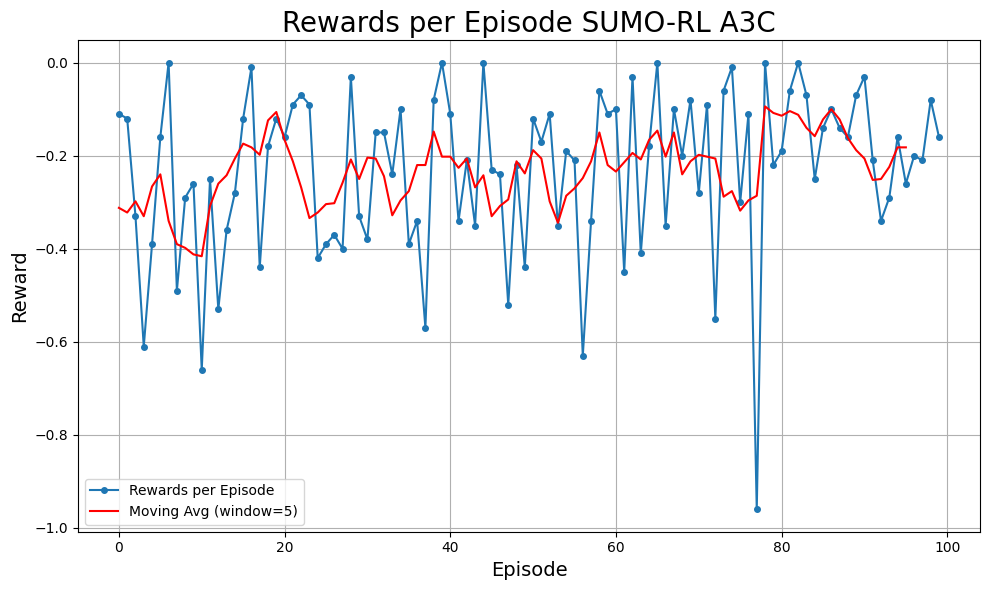

In [24]:
env_id = 'SUMO-RL A3C'
rewards_per_ep = torch.load('saved_variables/a3c_rewards.pkl')
rewards_per_episode_plot_2(rewards_per_ep, environment_type=env_id, window_size=5)